<a href="https://colab.research.google.com/github/vgonzalezg0/PROYECTO-IA/blob/main/03_Modelos_e_Iteraciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MODELOS E ITERACIONES**


El objetivo de este notebook es iterar y ajustar diferentes modelos predictivos, evaluar su desempeño utilizando métricas relevantes, seleccionar el mejor modelo, y prepararlo para el despliegue en producción, con el fin de proporcionar una solución integral y reproducible para el problema predictivo en cuestión.

[Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk)




## **Exploración de datos**

### Librerías

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#bibliotecas de machine learning 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn import utils
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, cross_validate, GridSearchCV, learning_curve, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

### Base de Datos 
 

#### Carga de datos mediante la API de Kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"valeria1gonzalez","key":"f8d6f4d22cae687bb41dd1736694e5bd"}'}

In [3]:
ls -a ~

./   .bashrc*  .config/   .jupyter/  .local/  .profile     .wget-hsts
../  .cache/   .ipython/  .keras/    .npm/    .tmux.conf*


In [4]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c home-credit-default-risk
! unzip home-credit-default-risk.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 686M/688M [00:11<00:00, 146MB/s]
100% 688M/688M [00:11<00:00, 64.5MB/s]
Archive:  home-credit-default-risk.zip
  inflating: HomeCredit_columns_description.csv  
  inflating: POS_CASH_balance.csv    
  inflating: application_test.csv    
  inflating: application_train.csv   
  inflating: bureau.csv              
  inflating: bureau_balance.csv      
  inflating: credit_card_balance.csv  
  inflating: installments_payments.csv  
  inflating: previous_application.csv  
  inflating: sample_submission.csv   


In [5]:
train = pd.read_csv("application_train.csv")
# test = pd.read_csv("application_test.csv")

#### Carga de datos mediante Google Drive

In [6]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [7]:
# train = pd.read_csv('/content/gdrive/MyDrive/application_train.csv')
# test = pd.read_csv('/content/gdrive/MyDrive/application_test.csv')

In [8]:
# train = pd.read_csv('/content/gdrive/MyDrive/2023 - 1/IA/application_train.csv')
# test = pd.read_csv('/content/gdrive/MyDrive/2023 - 1/IA/application_test.csv')

### Información

In [9]:
train.info

<bound method DataFrame.info of         SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0        

In [10]:
duplicates = train.duplicated()
print("Número de filas duplicadas:", duplicates.sum())
duplicates = train['SK_ID_CURR'].duplicated()
print("Número de valores duplicados en la columna SK_ID_CURR:", duplicates.sum())

Número de filas duplicadas: 0
Número de valores duplicados en la columna SK_ID_CURR: 0


### Variable Objetivo

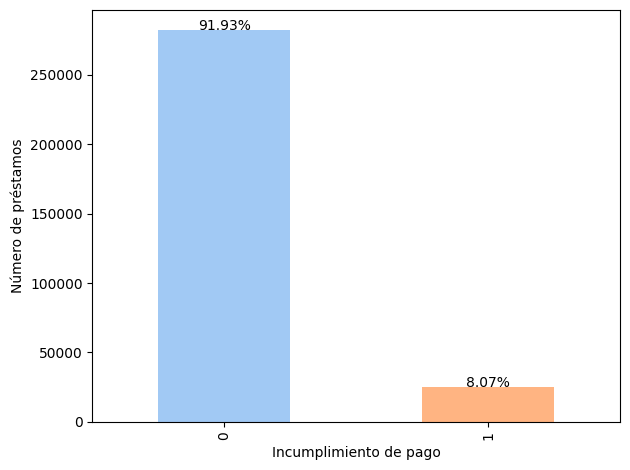

In [11]:
counts = train['TARGET'].value_counts()

ax = counts.plot(kind='bar', color=sns.color_palette("pastel"))

for p in ax.patches:
    ax.annotate(f'{p.get_height() / len(train) * 100:.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline')

#plt.legend(labels = ['Préstamos pagados', 'Préstamos no pagados'], loc="best")

#plt.title('Comportamiento de la variable objetivo')
plt.xlabel('Incumplimiento de pago')
plt.ylabel('Número de préstamos')

plt.tight_layout()
plt.show()

### Variables - Columnas

In [12]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

#### Numéricas

In [13]:
ncols = [i for i in train.columns if i in train._get_numeric_data()]
print(f"{len(ncols)} variables numéricas: \n{ncols}")

106 variables numéricas: 
['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGI

In [14]:
train._get_numeric_data().describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


Gráficos de los histogramas de las distribuciones de las variables

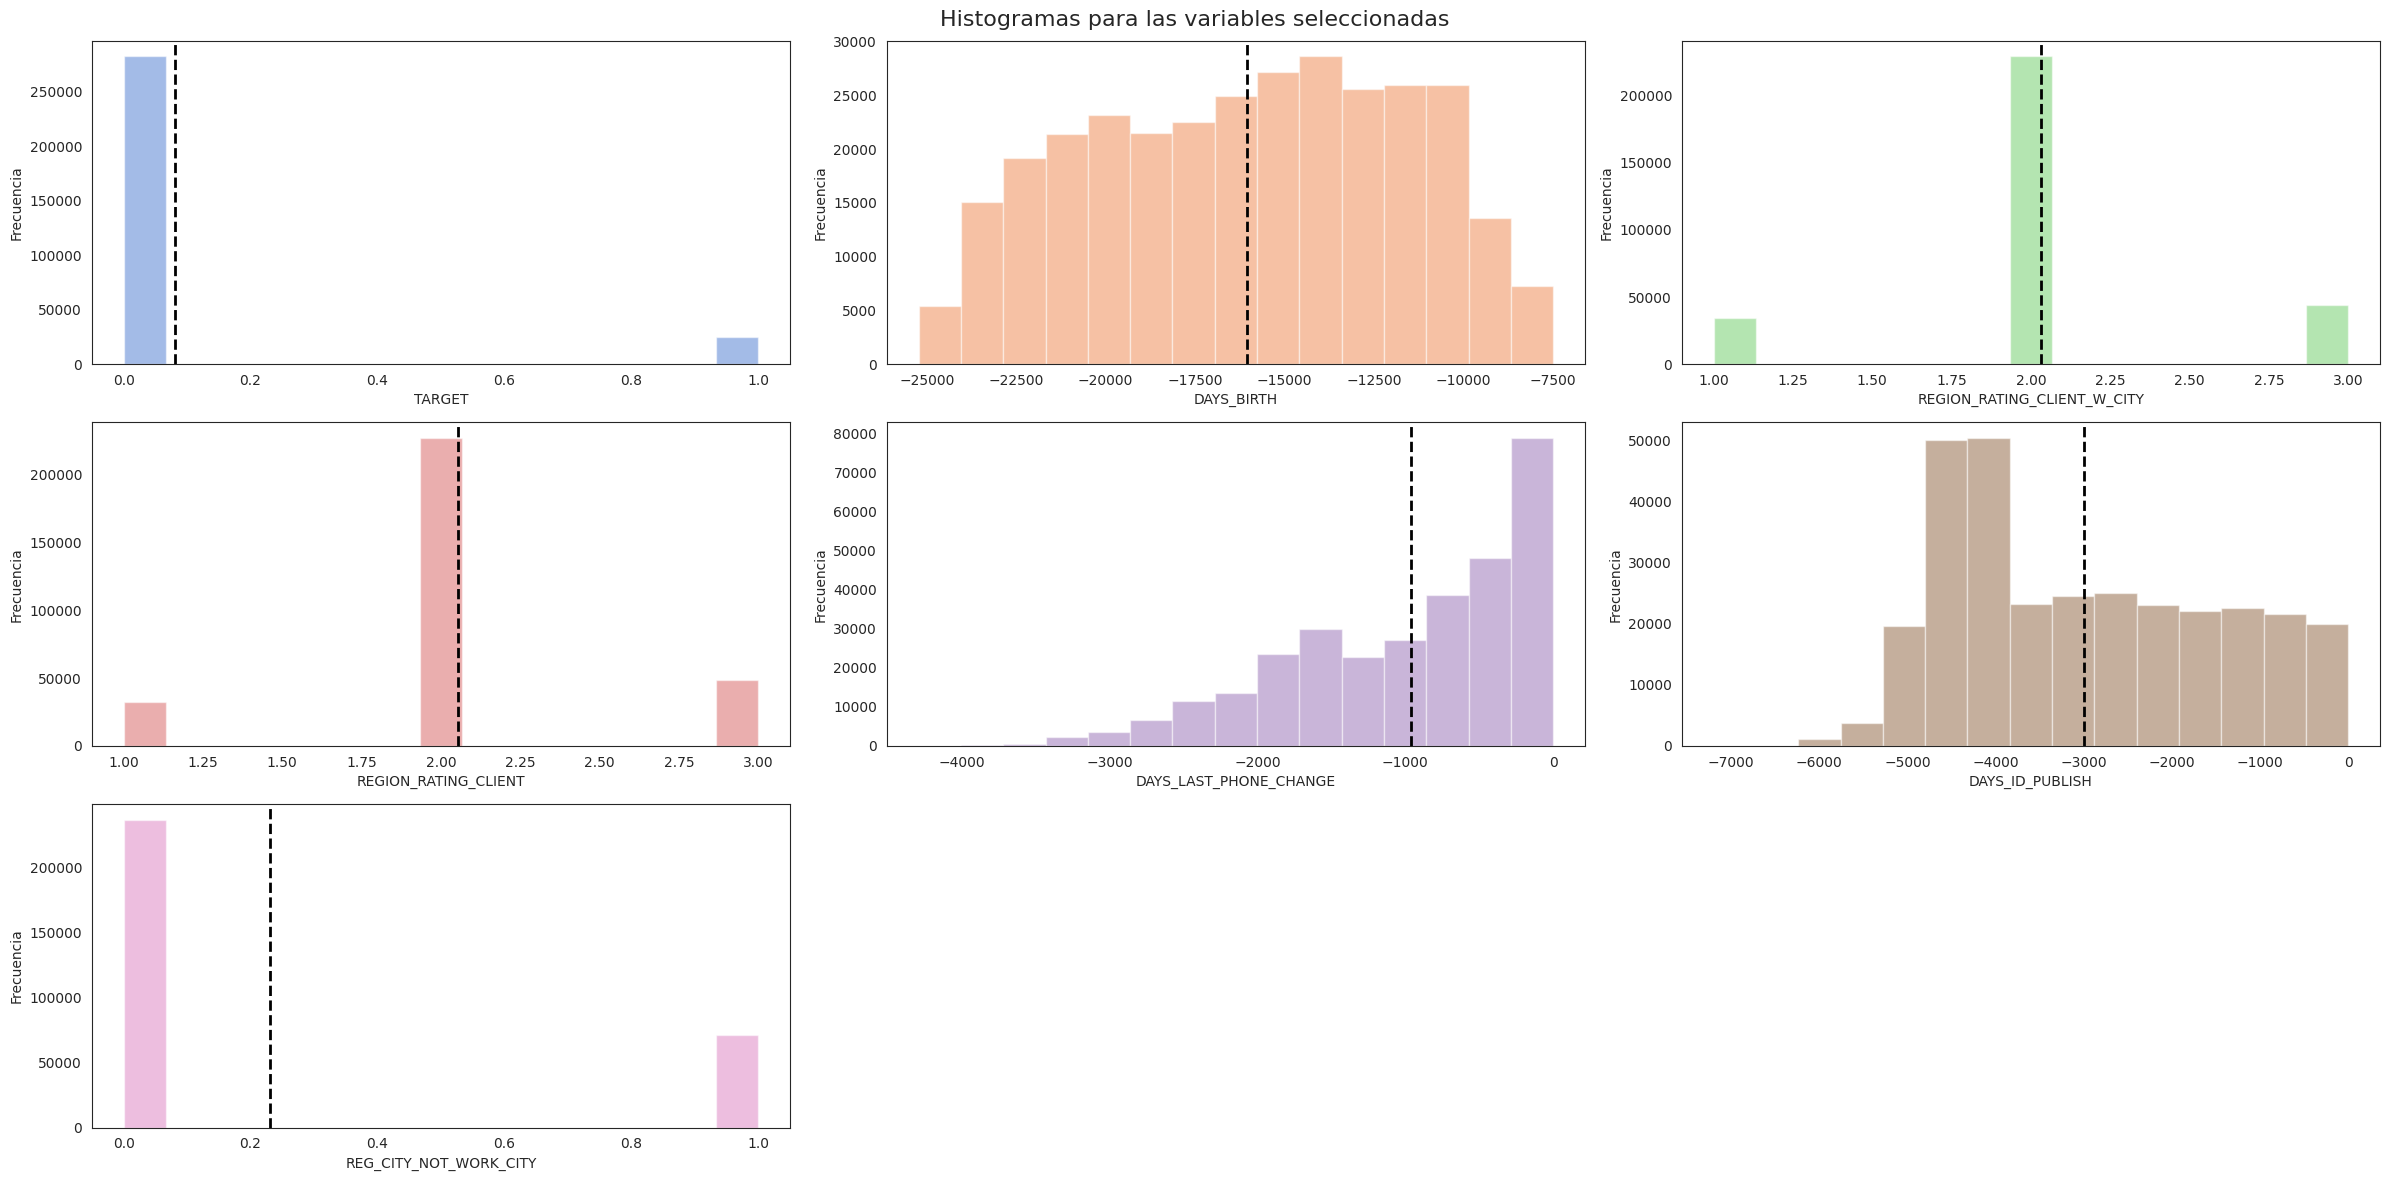

In [15]:
# determinar correlación con la variable objetivo
corr = train.corr()['TARGET'].sort_values(ascending=False)

sns.set_style("white")
palette = sns.color_palette("muted")

# seleccionar columnas con mayor correlación
cols = corr[corr >= 0.05].index.tolist()

if len(cols) > 0:
    
     # definir tamaño de la figura
    n_rows = (len(cols) // 3) + (len(cols) % 3 > 0)
    plt.figure(figsize=(24, 4 * n_rows))

    for i, col in enumerate(cols):
        plt.subplot(n_rows, 3, i+1)
        plt.hist(train[col], bins=15, color=palette[i], alpha=0.5)
        
        # agregar línea de media
        plt.axvline(train[col].mean(), color='black', linestyle='dashed', linewidth=2)

        plt.xlabel(col)
        plt.ylabel('Frecuencia')

    plt.suptitle('Histogramas para las variables seleccionadas', fontsize=16)
    plt.tight_layout()
    plt.show()

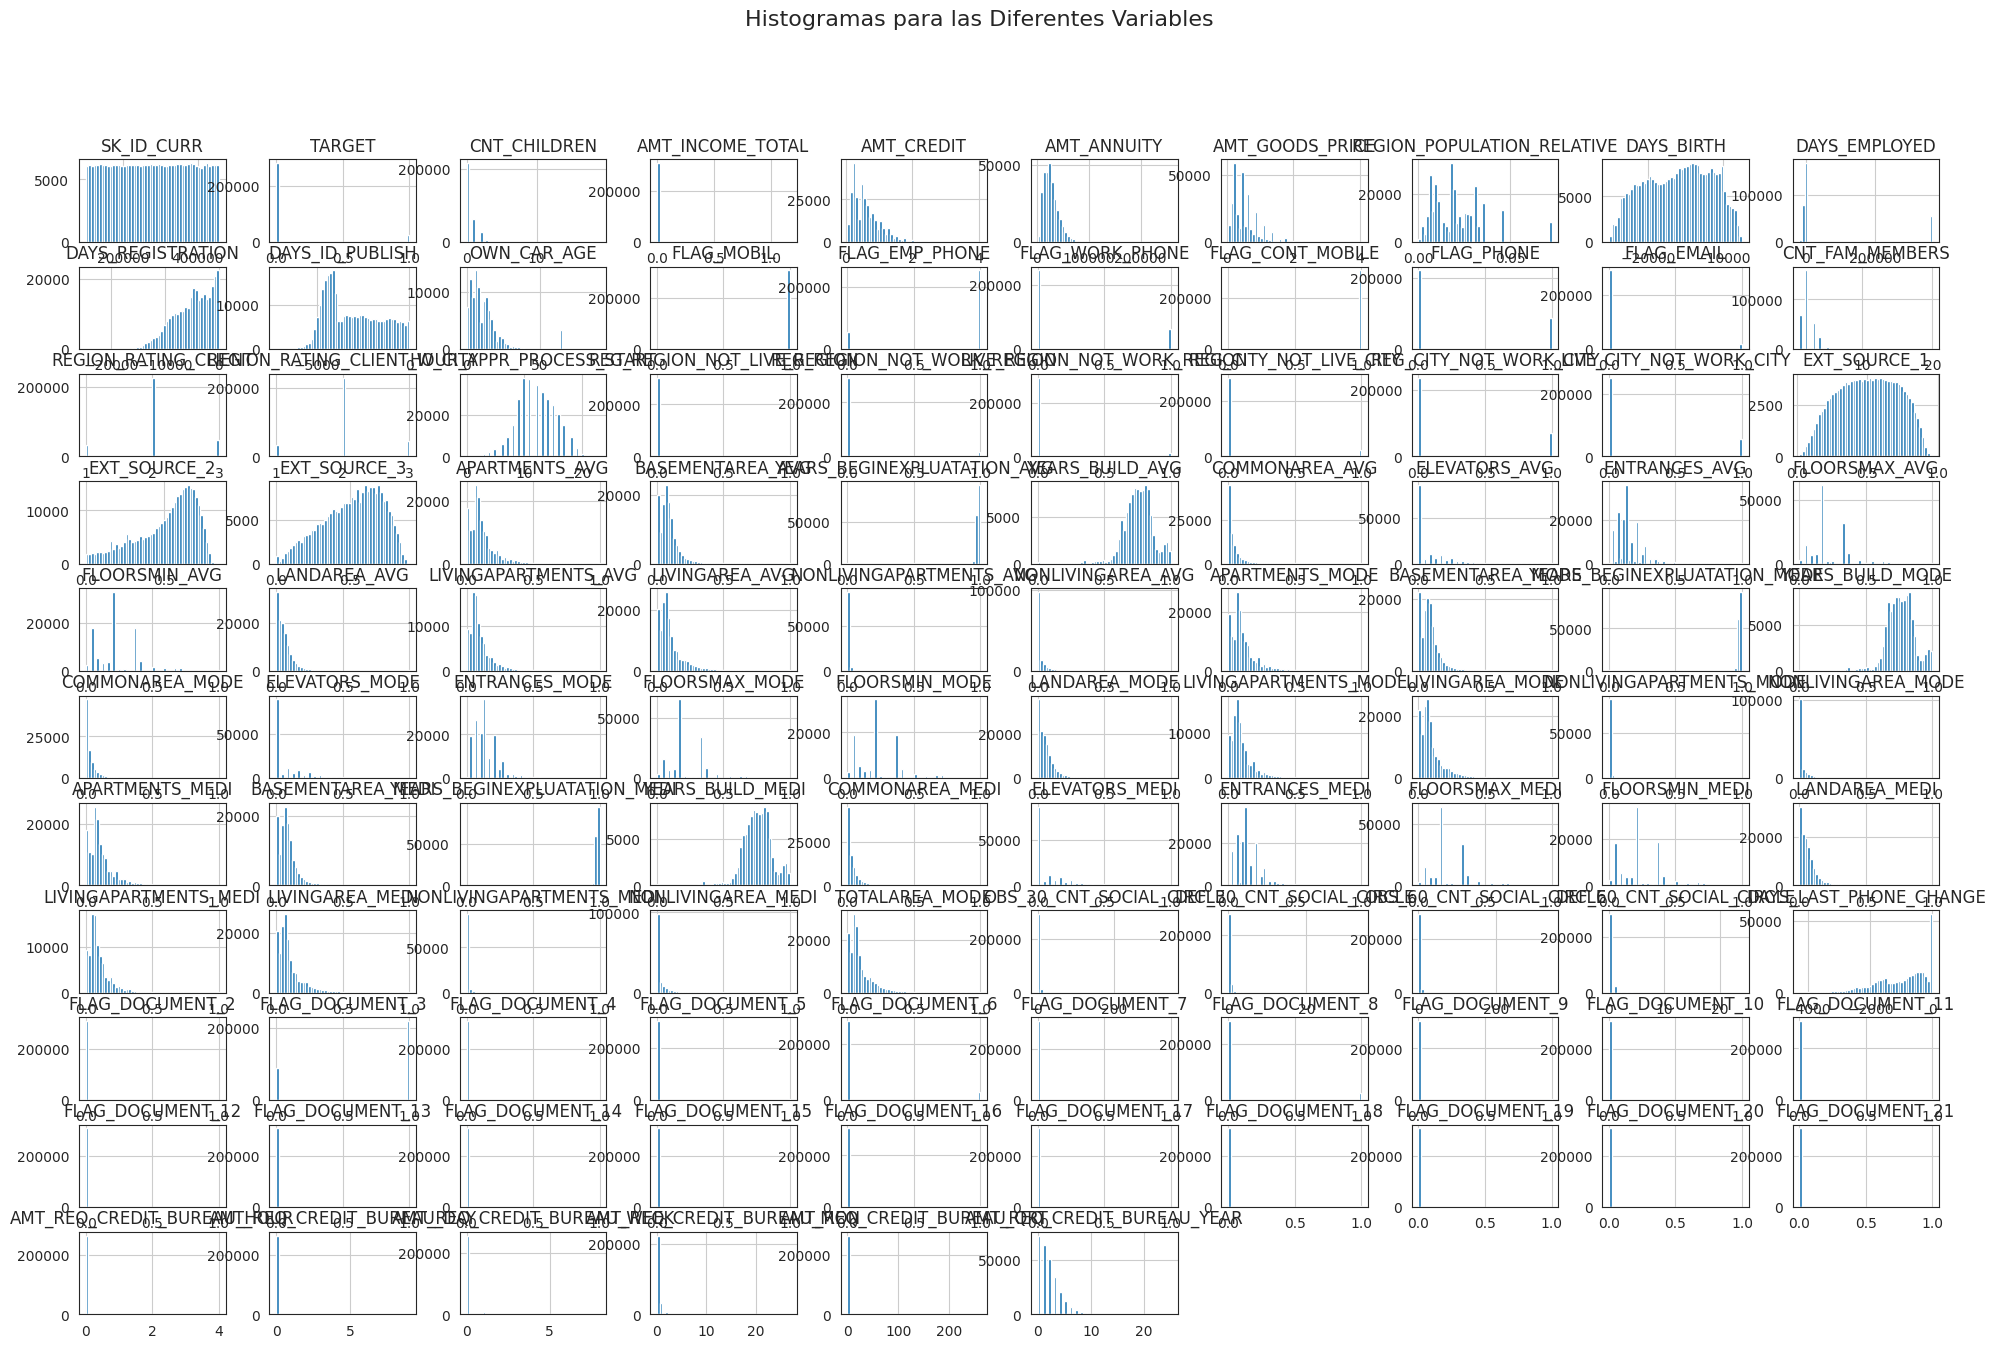

In [16]:
train.hist(bins = 50, figsize = (24, 15))
plt.suptitle('Histogramas para las Diferentes Variables', fontsize = 16)
plt.show()

#### Categóricas

In [17]:
ccols = [i for i in train.columns if not i in train._get_numeric_data()]
print(f"{len(ccols)} variables categóricas: \n{ccols}")
for c in ccols:
    print ("\n"+"%10s"%c, np.unique(train[c].dropna()))

16 variables categóricas: 
['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

NAME_CONTRACT_TYPE ['Cash loans' 'Revolving loans']

CODE_GENDER ['F' 'M' 'XNA']

FLAG_OWN_CAR ['N' 'Y']

FLAG_OWN_REALTY ['N' 'Y']

NAME_TYPE_SUITE ['Children' 'Family' 'Group of people' 'Other_A' 'Other_B'
 'Spouse, partner' 'Unaccompanied']

NAME_INCOME_TYPE ['Businessman' 'Commercial associate' 'Maternity leave' 'Pensioner'
 'State servant' 'Student' 'Unemployed' 'Working']

NAME_EDUCATION_TYPE ['Academic degree' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Secondary / secondary special']

NAME_FAMILY_STATUS ['Civil marriage' 'Married' 'Separated' 'Single / not married' 'Unknown'
 'Widow']

NAME_HOUSING_TYPE ['Co-

#### Correlaciones


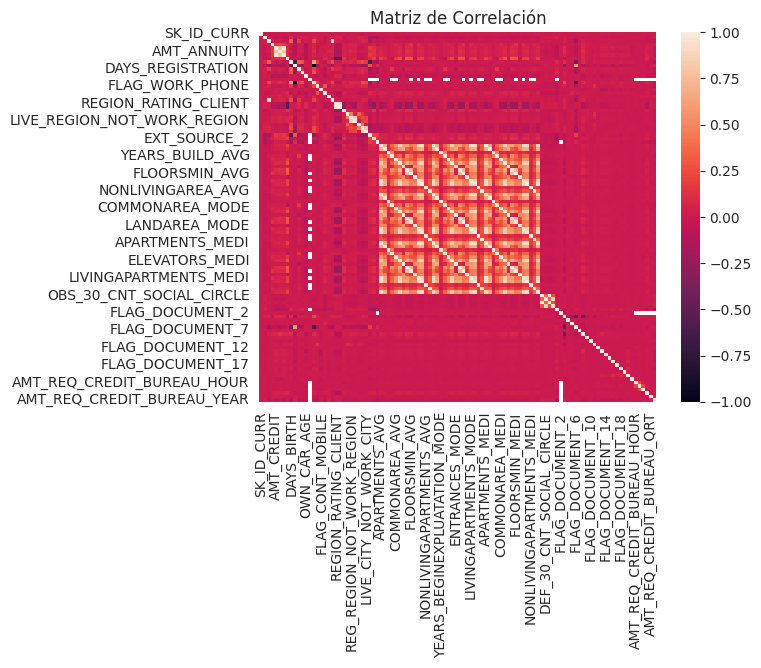

In [18]:
corr_matrix = train.corr()

sns.heatmap(corr_matrix, annot = False, vmin = -1, vmax = 1).set_title('Matriz de Correlación')
plt.show()

In [19]:
# Calcular la correlación entre las variables y el target
corr_matrix = train.corr()
corr_with_target = corr_matrix["TARGET"].sort_values(ascending=False)

In [20]:
# Seleccionar las 20 variables con mayor correlación con el target
selected_vars = corr_with_target[1:21].index.tolist()
train_selected = train[selected_vars]

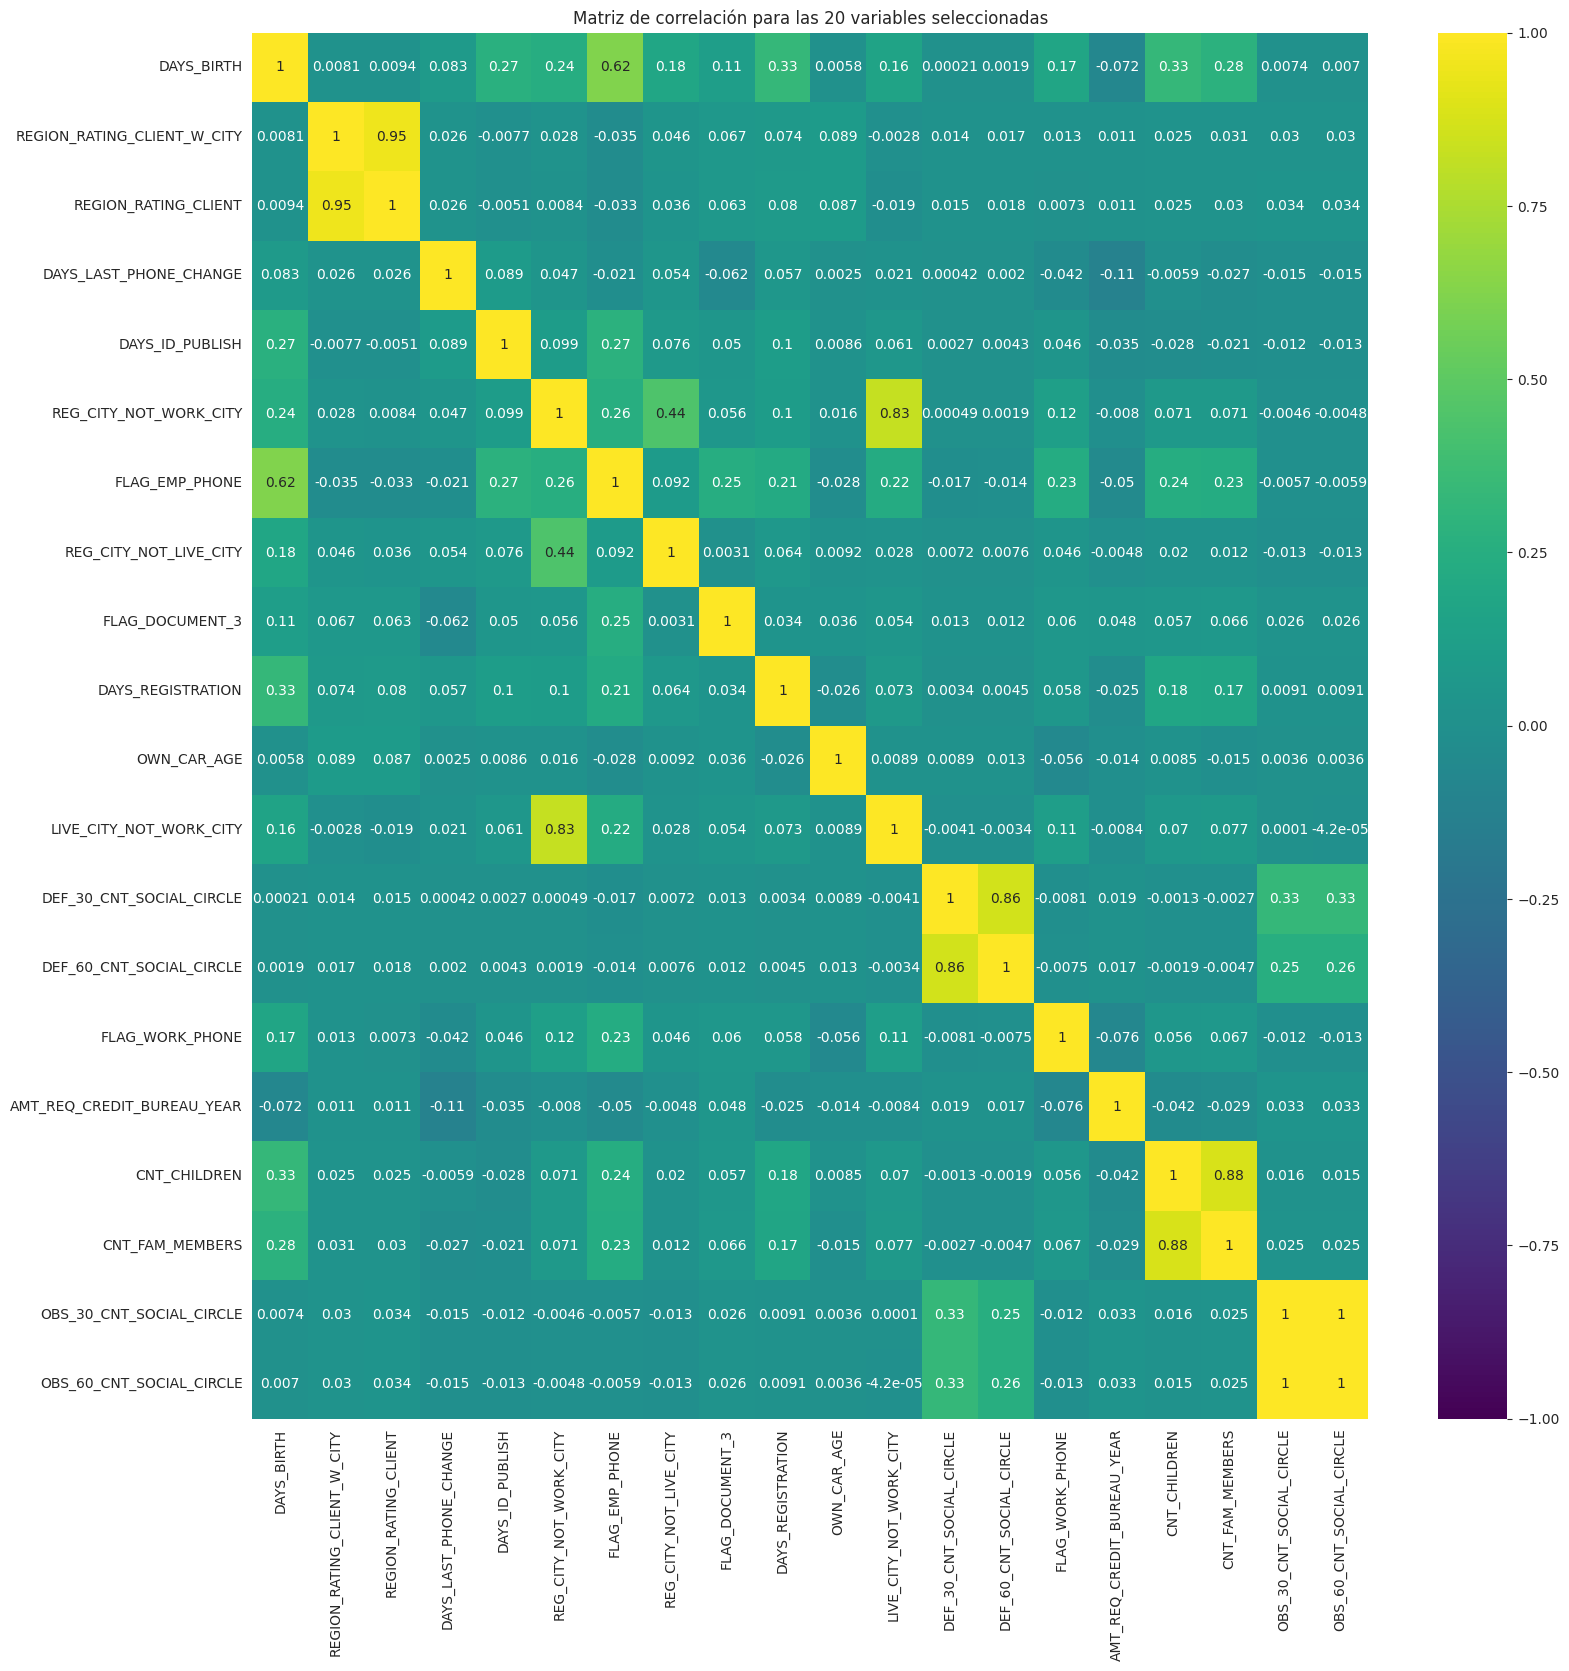

In [21]:
# Generar heatmap
plt.figure(figsize=(18,18))
corr_matrix = train_selected.corr()
sns.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1, cmap = "viridis").set_title('Matriz de correlación para las 20 variables seleccionadas')
plt.show()

In [22]:
#Correlaciones de las variables con la variable objetivo
corr = train.corr()['TARGET'].sort_values(ascending=False)
corr[corr >= 0.05].to_frame()

,TARGET
TARGET,1.000000
DAYS_BIRTH,0.078239
REGION_RATING_CLIENT_W_CITY,0.060893
REGION_RATING_CLIENT,0.058899
DAYS_LAST_PHONE_CHANGE,0.055218
DAYS_ID_PUBLISH,0.051457
REG_CITY_NOT_WORK_CITY,0.050994


## Limpieza de datos

### 1. Datos faltantes

In [23]:
k = train.isna().sum()
print(f"Datos Faltantes por Columna: \n\n{k[k!=0]}")

Datos Faltantes por Columna: 

AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
NAME_TYPE_SUITE                 1292
OWN_CAR_AGE                   202929
OCCUPATION_TYPE                96391
                               ...  
AMT_REQ_CREDIT_BUREAU_DAY      41519
AMT_REQ_CREDIT_BUREAU_WEEK     41519
AMT_REQ_CREDIT_BUREAU_MON      41519
AMT_REQ_CREDIT_BUREAU_QRT      41519
AMT_REQ_CREDIT_BUREAU_YEAR     41519
Length: 67, dtype: int64


Porcentaje

In [24]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending=False)
missing_train = pd.concat([total,percent],axis=1,keys=["Total","Percent"])
missing_train.head()

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963


In [25]:
missing_train.head()

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963


Del análisis exploratorio de las variables, se encontró que se tienen variables que contienen gran cantidad de datos faltantes. Se opta por eliminar las columnas en las que los datos faltantes representen el 50% o más de la totalidad de los datos.

In [26]:
criterio = len(train) * 0.5 #criterio para eliminar la columna (50% de las filas que se tienen)
train.dropna(axis=1, thresh = criterio, inplace = True) #eliminación de las columnas con 50% o más de datos faltantes
print('Nuevas dimensiones:',train.shape)

Nuevas dimensiones: (307511, 81)


In [27]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending=False)
missing_train = pd.concat([total,percent],axis=1,keys=["Total","Percent"])
missing_train

,Total,Percent
FLOORSMAX_AVG,153020,49.760822
FLOORSMAX_MODE,153020,49.760822
FLOORSMAX_MEDI,153020,49.760822
YEARS_BEGINEXPLUATATION_AVG,150007,48.781019
YEARS_BEGINEXPLUATATION_MODE,150007,48.781019
...,...,...
NAME_HOUSING_TYPE,0,0.000000
NAME_FAMILY_STATUS,0,0.000000
NAME_EDUCATION_TYPE,0,0.000000
NAME_INCOME_TYPE,0,0.000000


In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 81 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    307511 non-null  int64  
 1   TARGET                        307511 non-null  int64  
 2   NAME_CONTRACT_TYPE            307511 non-null  object 
 3   CODE_GENDER                   307511 non-null  object 
 4   FLAG_OWN_CAR                  307511 non-null  object 
 5   FLAG_OWN_REALTY               307511 non-null  object 
 6   CNT_CHILDREN                  307511 non-null  int64  
 7   AMT_INCOME_TOTAL              307511 non-null  float64
 8   AMT_CREDIT                    307511 non-null  float64
 9   AMT_ANNUITY                   307499 non-null  float64
 10  AMT_GOODS_PRICE               307233 non-null  float64
 11  NAME_TYPE_SUITE               306219 non-null  object 
 12  NAME_INCOME_TYPE              307511 non-nul

Una vez eliminadas las columnas con más del 50% de datos faltantes, tratamos el resto de los datos faltantes por medio de la imputación por media y moda según el tipo de dato de la variable


In [29]:
null_cols = train.columns[train.isnull().any()]

In [30]:
for col in null_cols:
    if train[col].dtype == 'object':
        train[col].fillna(train[col].mode()[0], inplace = True)
    else:
        train[col].fillna(train[col].mean(), inplace = True)

In [31]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending=False)
missing_train = pd.concat([total,percent],axis=1,keys=["Total","Percent"])
missing_train

,Total,Percent
SK_ID_CURR,0,0.0
EXT_SOURCE_3,0,0.0
FLAG_DOCUMENT_6,0,0.0
FLAG_DOCUMENT_5,0,0.0
FLAG_DOCUMENT_4,0,0.0
...,...,...
FLAG_EMAIL,0,0.0
FLAG_PHONE,0,0.0
FLAG_CONT_MOBILE,0,0.0
FLAG_WORK_PHONE,0,0.0


In [32]:
le = LabelEncoder()
for col in train.columns:
    if train[col].dtype == 'object':
        if len(train[col].unique()) <= 2:
            le.fit(train[col])
            train[col] = le.transform(train[col])
        else:
            train = pd.get_dummies(train, columns=[col], drop_first=True)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 181 entries, SK_ID_CURR to ORGANIZATION_TYPE_XNA
dtypes: float64(27), int64(45), uint8(109)
memory usage: 200.9 MB


Es importante verificar que no queden datos vacíos en el conjunto de datos final.

In [33]:
k = train.isna().sum()
k[k!=0]

Series([], dtype: int64)

In [34]:
#Debe ser 0
print(train.isna().sum().sum())

0


In [35]:
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,0,0,157500.0,254700.0,27558.0,225000.0,...,0,0,0,0,0,0,0,0,0,0
307507,456252,0,0,0,1,0,72000.0,269550.0,12001.5,225000.0,...,0,0,0,0,0,0,0,0,0,1
307508,456253,0,0,0,1,0,153000.0,677664.0,29979.0,585000.0,...,0,0,0,0,0,0,0,0,0,0
307509,456254,1,0,0,1,0,171000.0,370107.0,20205.0,319500.0,...,0,0,0,0,0,0,0,0,0,0


## Modelos Supervisados


In [36]:
train_ = train.sample(n = 5000, random_state = 42)
X = train_.drop(columns=['TARGET'])
y = train_['TARGET']
X.shape, y.shape

((5000, 180), (5000,))

In [37]:
def report_cv_score(z):
    print ("test score   %.3f (±%.4f) with %d splits"%(np.mean(z["test_score"]), np.std(z["test_score"]), len(z["test_score"])))
    print ("train score  %.3f (±%.4f) with %d splits"%(np.mean(z["train_score"]), np.std(z["train_score"]), len(z["train_score"])))

In [38]:
test_size = 0.3
val_size  = test_size/(1-test_size)

print("Test size %.2f"%test_size)
print("Val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(X, y, test_size=test_size)
print(Xtv.shape, Xts.shape)

Test size 0.30
Val size is 0.43 (relative to 0.70) 
(3500, 180) (1500, 180)


In [42]:
def evaluate_auc(model, Xtv, ytv, Xts, yts):
    model.fit(Xtv, ytv)
    y_pred_prob = model.predict_proba(Xts)[:, 1]
    auc = roc_auc_score(yts, y_pred_prob)
    print("AUC of {}: {}".format(model, auc))

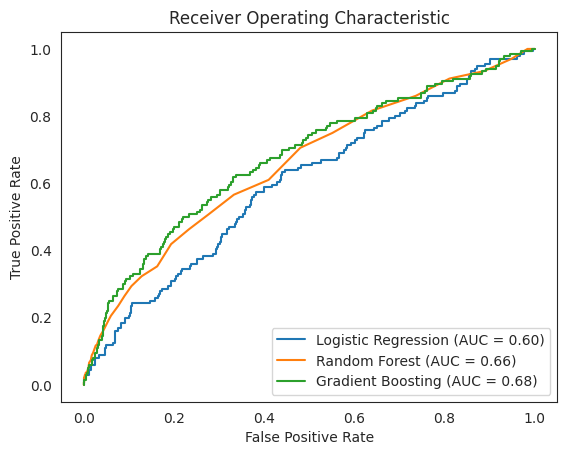

In [40]:
estimators = {'Logistic Regression': LogisticRegression(),
              'Random Forest': RandomForestClassifier(),
              'Gradient Boosting': GradientBoostingClassifier()}
               #Naive Bayes': GaussianNB() 
for name, estimator in estimators.items():
  estimator.fit(Xtv, ytv)
  
  y_pred_prob = estimator.predict_proba(Xts)[:, 1]
  
  # Curva ROC y AUC
  fpr, tpr, thresholds = roc_curve(yts, y_pred_prob)
  roc_auc = auc(fpr, tpr)
  
  plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
  plt.legend(loc='lower right')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  
plt.show()

In [43]:
zscores = []
for name, estimator in estimators.items():
    print("------------------\n", name)
    
    z = cross_validate(estimator, Xtv, ytv, return_train_score=True, return_estimator=False,
                       scoring='roc_auc', cv=KFold(n_splits=10))
    report_cv_score(z)
    zscores.append(np.mean(z["test_score"]))

best_idx = np.argmax(zscores)
best_estimator_name = list(estimators.keys())[best_idx]
best_estimator = list(estimators.values())[best_idx]

print("------------------\nSelected model:")
print(best_estimator_name)
print(best_estimator)

------------------
 Logistic Regression
test score   0.638 (±0.0589) with 10 splits
train score  0.667 (±0.0111) with 10 splits
------------------
 Random Forest
test score   0.662 (±0.0728) with 10 splits
train score  1.000 (±0.0000) with 10 splits
------------------
 Gradient Boosting
test score   0.688 (±0.0574) with 10 splits
train score  0.946 (±0.0053) with 10 splits
------------------
Selected model:
Gradient Boosting
GradientBoostingClassifier()


In [44]:
evaluate_auc(best_estimator, Xtv, ytv, Xts, yts)

AUC of GradientBoostingClassifier(): 0.6733224081421424


### Mejores Hiperpárametros

#### Random Forest

In [45]:
param_grid_rf = {'n_estimators': [100, 200, 300],
                  'max_depth': [None, 5, 10]}

# Búsqueda de hiperparámetros
grid_search_rf = GridSearchCV(estimators['Random Forest'], param_grid_rf, cv=5)
grid_search_rf.fit(Xtv, ytv)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'n_estimators': [100, 200, 300]})

In [46]:
best_model_rf = grid_search_rf.best_estimator_
print("Best Random Forest: ", best_model_rf)
print("Best Hyperparameters for Random Forest: ", grid_search_rf.best_params_)

Best Random Forest:  RandomForestClassifier()
Best Hyperparameters for Random Forest:  {'max_depth': None, 'n_estimators': 100}


In [47]:
evaluate_auc(best_model_rf, Xtv, ytv, Xts, yts)

AUC of RandomForestClassifier(): 0.6487002975677075


In [48]:
# print("Best Model AUC-ROC for Random Forest:", roc_auc_score(yts , best_model_rf.predict(Xts)))

In [49]:
def lc_plot(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, scoring='roc_auc')

    # Medias y desviaciones estándar de entrenamiento y prueba
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Curvas de aprendizaje
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='r', label='Train Score')
    plt.plot(train_sizes, test_mean, 'o-', color='g', label='Test Score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
    plt.xlabel('Training Set Size')
    plt.ylabel('ROC-AUC Score')
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.show()  

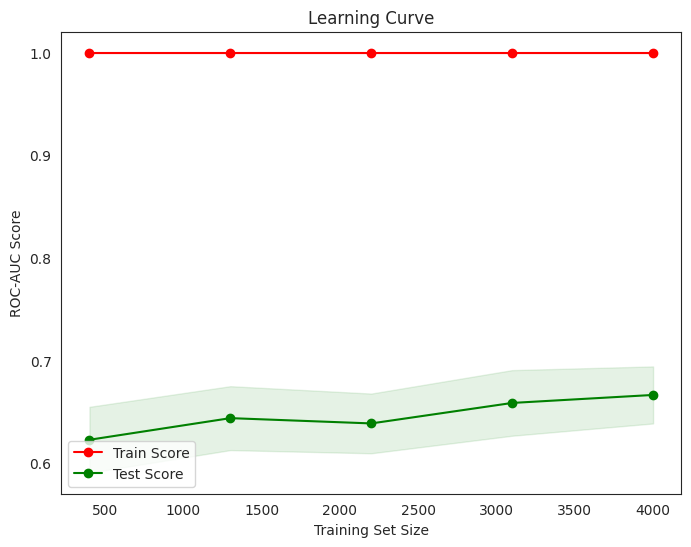

In [50]:
lc_plot(best_model_rf, X, y)

####Gradient Boosting

In [51]:
param_grid_gb = {'n_estimators': [100, 200, 300],
                  'learning_rate': [0.1, 0.01, 0.001]}

# Búsqueda de hiperparámetros
grid_search_gb = GridSearchCV(estimators['Gradient Boosting'], param_grid_gb, cv=5)
grid_search_gb.fit(Xtv, ytv)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'n_estimators': [100, 200, 300]})

In [52]:
best_model_gb = grid_search_gb.best_estimator_
print("Best Gradient Boosting: ", best_model_gb)
print("Best Hyperparameters for Gradient Boosting: ", grid_search_gb.best_params_)

Best Gradient Boosting:  GradientBoostingClassifier(learning_rate=0.001)
Best Hyperparameters for Gradient Boosting:  {'learning_rate': 0.001, 'n_estimators': 100}


In [53]:
evaluate_auc(best_model_gb, Xtv, ytv, Xts, yts)

AUC of GradientBoostingClassifier(learning_rate=0.001): 0.6105609582542695


In [54]:
# # Evaluación del mejor modelo
# print("Best Model AUC-ROC for Gradient Boosting:", roc_auc_score(yts , best_model_gb.predict(Xts)))

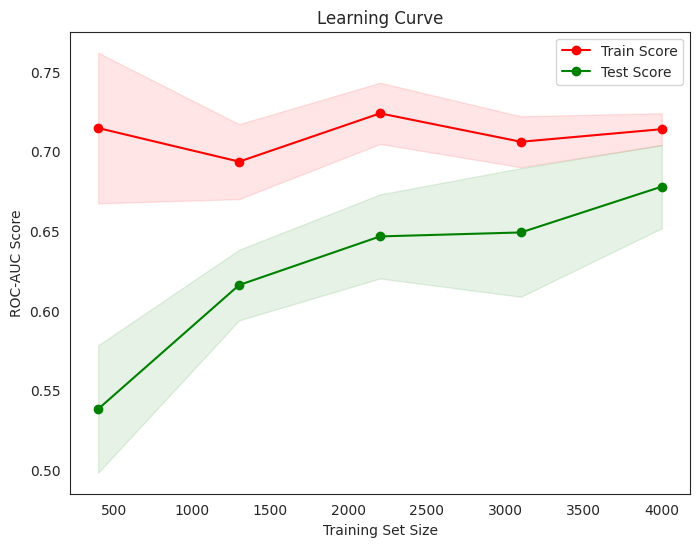

In [55]:
lc_plot(best_model_gb, X, y)

##Modelos no Supervisados

In [56]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [57]:
X.shape, y.shape

((5000, 180), (5000,))

### PCA

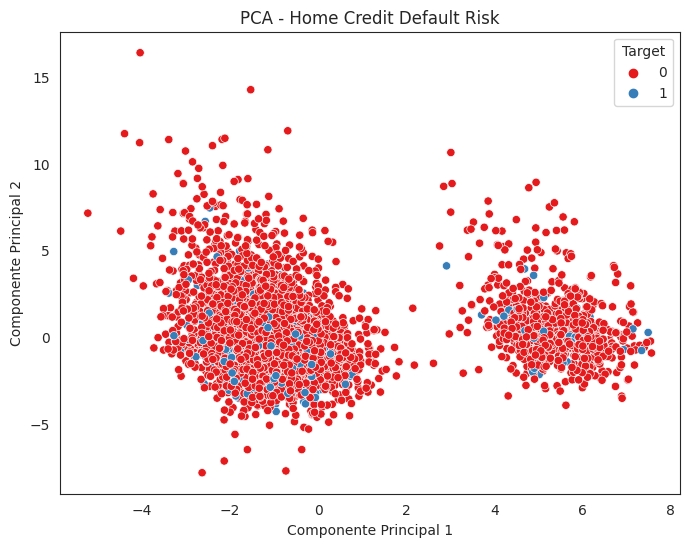

In [58]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Gráfico de dispersión 
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="Set1")
plt.title("PCA - Home Credit Default Risk")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Target")
plt.show()

###K-Means

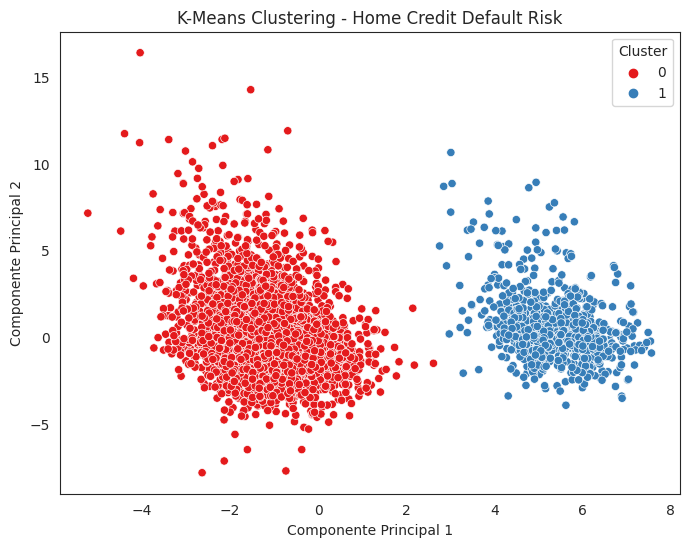

In [59]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_scaled)
cluster_labels = kmeans.labels_

# Gráfico de dispersión para los resultados de K-Means
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette="Set1")
plt.title("K-Means Clustering - Home Credit Default Risk")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.show()

###NMF

In [60]:
X_filtered = X.copy()
columns_with_negatives = X.columns[(X < 0).any()]
X_filtered = X_filtered.drop(columns_with_negatives, axis=1)

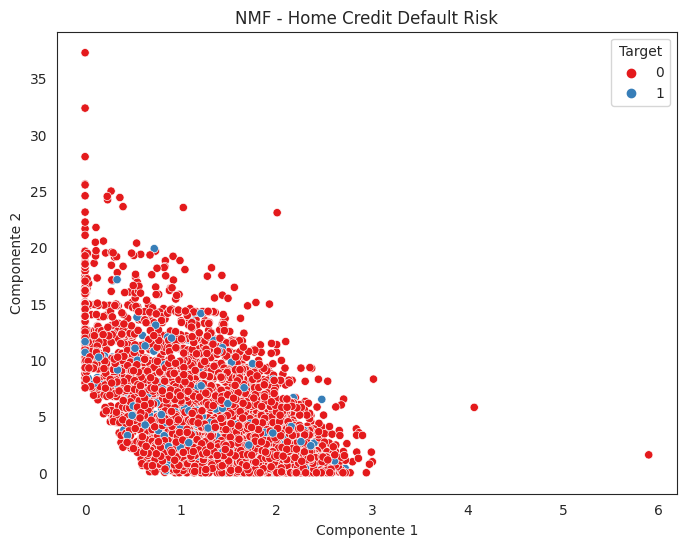

In [61]:
nmf = NMF(n_components=2)
X_nmf = nmf.fit_transform(X_filtered)

# Gráfico de dispersión 
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_nmf[:, 0], y=X_nmf[:, 1], hue=y, palette="Set1")
plt.title("NMF - Home Credit Default Risk")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title="Target")
plt.show()

## Algoritmo no Supervisado + Algoritmo Predictivo

### K-Means + Logistic Regression

In [62]:
combination1 = Pipeline([
    ('algorithm', KMeans()),
    ('predictor', LogisticRegression())
])

parameters_combination1 = {
    'algorithm__n_clusters': [2, 3, 4],
    'predictor__C': [0.1, 1, 10]
}

search1 = GridSearchCV(combination1, parameters_combination1, scoring='roc_auc', cv=5)
search1.fit(Xtv, ytv)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('algorithm', KMeans()),
                                       ('predictor', LogisticRegression())]),
             param_grid={'algorithm__n_clusters': [2, 3, 4],
                         'predictor__C': [0.1, 1, 10]},
             scoring='roc_auc')

In [63]:
best_model_combination1 = search1.best_estimator_
print("Best model combination 1: ", best_model_combination1)
print("Best Hyperparameters for model combination 1: ", search1.best_params_)

Best model combination 1:  Pipeline(steps=[('algorithm', KMeans(n_clusters=2)),
                ('predictor', LogisticRegression(C=10))])
Best Hyperparameters for model combination 1:  {'algorithm__n_clusters': 2, 'predictor__C': 10}


In [64]:
evaluate_auc(best_model_combination1, Xtv, ytv, Xts, yts)

AUC of Pipeline(steps=[('algorithm', KMeans(n_clusters=2)),
                ('predictor', LogisticRegression(C=10))]): 0.5673678195618423


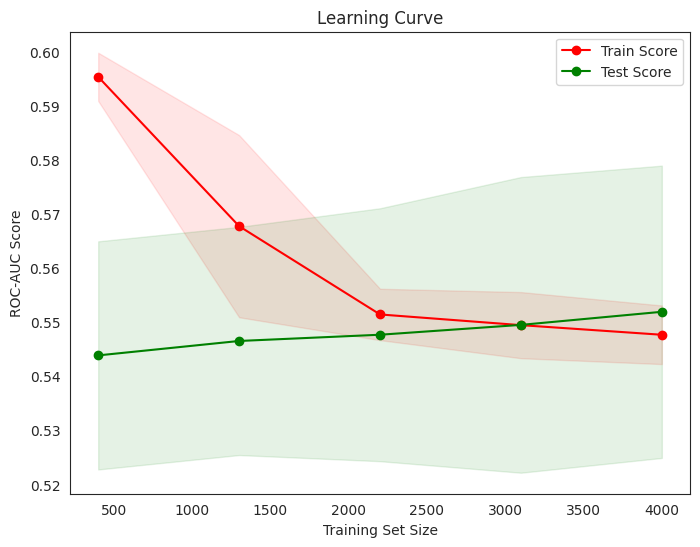

In [65]:
lc_plot(best_model_combination1, X, y)

### PCA + Logistic Regression

In [66]:
combination2 = Pipeline([
    ('algorithm', PCA()), 
    ('predictor', LogisticRegression())  
])

parameters_combination2 = {
    'algorithm__n_components': [2, 3, 4],  
    'predictor__C': [0.1, 1, 10]  
}
search2 = GridSearchCV(combination2, parameters_combination2, scoring='roc_auc', cv=5)
search2.fit(Xtv, ytv)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('algorithm', PCA()),
                                       ('predictor', LogisticRegression())]),
             param_grid={'algorithm__n_components': [2, 3, 4],
                         'predictor__C': [0.1, 1, 10]},
             scoring='roc_auc')

In [67]:
best_model_combination2 = search2.best_estimator_
print("Best model combination 2: ", best_model_combination2)
print("Best Hyperparameters for model combination 2: ", search2.best_params_)

Best model combination 2:  Pipeline(steps=[('algorithm', PCA(n_components=4)),
                ('predictor', LogisticRegression(C=0.1))])
Best Hyperparameters for model combination 2:  {'algorithm__n_components': 4, 'predictor__C': 0.1}


In [68]:
evaluate_auc(best_model_combination2, Xtv, ytv, Xts, yts)

AUC of Pipeline(steps=[('algorithm', PCA(n_components=4)),
                ('predictor', LogisticRegression(C=0.1))]): 0.5753299120234604


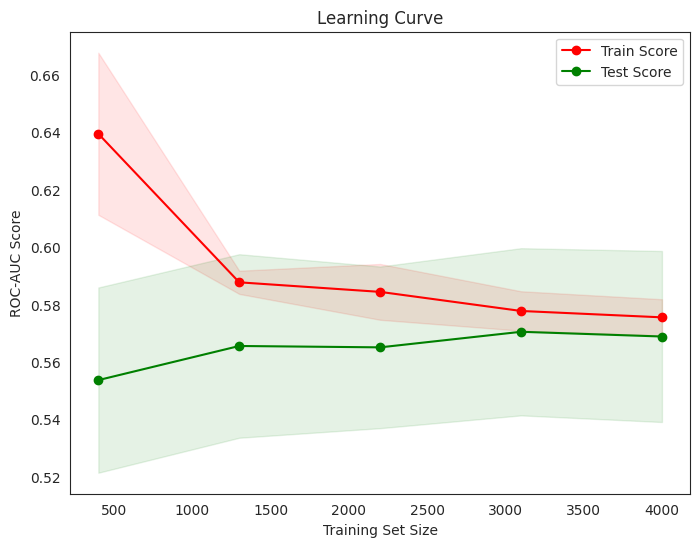

In [69]:
lc_plot(best_model_combination2, X, y)

### KMeans + Gradient Boosting

In [70]:
combination3 = Pipeline([
    ('algorithm', KMeans()), 
    ('predictor', GradientBoostingClassifier())  
])

parameters_combination3 = {
    'algorithm__n_clusters': [2, 3],  
    'predictor__n_estimators': [100, 200],
    'predictor__learning_rate': [0.1, 0.05]  

}
search3 = GridSearchCV(combination3, parameters_combination3, scoring='roc_auc', cv=5)
search3.fit(Xtv, ytv)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('algorithm', KMeans()),
                                       ('predictor',
                                        GradientBoostingClassifier())]),
             param_grid={'algorithm__n_clusters': [2, 3],
                         'predictor__learning_rate': [0.1, 0.05],
                         'predictor__n_estimators': [100, 200]},
             scoring='roc_auc')

In [71]:
best_model_combination3 = search3.best_estimator_
print("Best model combination 3: ", best_model_combination3)
print("Best Hyperparameters for model combination 2: ", search3.best_params_)

Best model combination 3:  Pipeline(steps=[('algorithm', KMeans(n_clusters=2)),
                ('predictor', GradientBoostingClassifier(n_estimators=200))])
Best Hyperparameters for model combination 2:  {'algorithm__n_clusters': 2, 'predictor__learning_rate': 0.1, 'predictor__n_estimators': 200}


In [72]:
evaluate_auc(best_model_combination3, Xtv, ytv, Xts, yts)

AUC of Pipeline(steps=[('algorithm', KMeans(n_clusters=2)),
                ('predictor', GradientBoostingClassifier(n_estimators=200))]): 0.5682411160945317


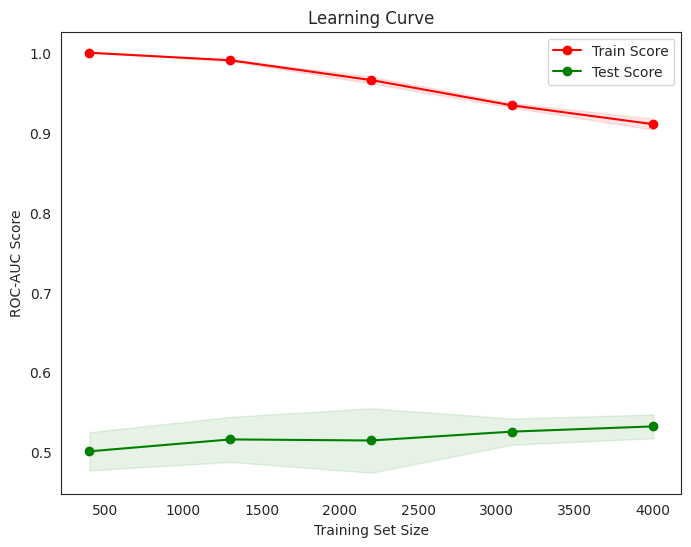

In [73]:
lc_plot(best_model_combination3, X, y)

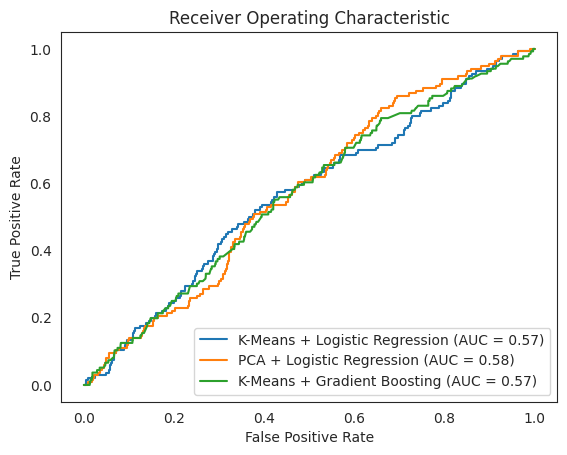

In [74]:
best_combinations = [best_model_combination1, best_model_combination2, best_model_combination3]
combination_labels = ['K-Means + Logistic Regression', 'PCA + Logistic Regression', 'K-Means + Gradient Boosting']

fprs = []
tprs = []
aucs = []

for combination, label in zip(best_combinations, combination_labels):
    y_pred_prob = combination.predict_proba(Xts)[:, 1]

    fpr, tpr, _ = roc_curve(yts, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)
    
    plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(label, roc_auc))

plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()

### Otras combinaciones de algoritmos que tienen un mayor costo computacional

In [75]:
## NMF computacionalmente costoso
# combination4 = Pipeline([
#     ('algorithm', NMF()),
#     ('predictor', RandomForestClassifier())
# ])

# parameters_combination4 = {
#     'algorithm__n_components': [2, 3],
#     'predictor__n_estimators': [100, 200]
# }


# combination5 = Pipeline([
#     ('algorithm', PCA()), 
#     ('predictor', GradientBoostingClassifier())  
# ])

# parameters_combination5 = {
#     'algorithm__n_components': [2, 3],  
#     'predictor__n_estimators': [100, 200]
#     'predictor__learning_rate': [0.1, 0.05]  
# }


# combination6 = Pipeline([
#     ('algorithm', PCA()), 
#     ('predictor', RandomForestClassifier())  
# ])

# parameters_combination6 = {
#     'algorithm__n_components': [2, 3, 4],  
#     'predictor__n_estimators': [100, 200, 300]  
# }